In [2]:
#!pip install lightgbm
#!pip install catboost
#!pip install tensorflow
#!pip install --upgrade tensorflow
#library to use KerasClassifier
#!pip install scikeras

timestamp - A timestamp for the minute covered by the row.
Asset_ID - An ID code for the cryptoasset.
Count - The number of trades that took place this minute.
Open - The USD price at the beginning of the minute.
High - The highest USD price during the minute.
Low - The lowest USD price during the minute.
Close - The USD price at the end of the minute.
Volume - The number of cryptoasset units traded during the minute.
VWAP - The volume weighted average price for the minute.
Target - 15 minute residualized returns. 

In [25]:
######################
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from sklearn.linear_model import LogisticRegressionCV , LogisticRegression
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV , cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import catboost as cb
import xgboost as xgb
import os
import matplotlib.pyplot as plt
import io
from prettytable import PrettyTable
# Importing tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten , Dense , Softmax , Dropout
from tensorflow.keras import optimizers
# Libraries to use ANN
import scikeras
from scikeras.wrappers import KerasRegressor

In [27]:
train_data = pd.read_csv("C:\\Users\\Faheem\\Downloads\\train.csv (2)\\train.csv")
train_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [28]:
btc = train_data[train_data["Asset_ID"]==1].set_index("timestamp")

In [29]:
btc.index.name = None

In [30]:
btc.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [31]:
train_data = btc

In [32]:
start_data = train_data.index[0].astype('datetime64[s]')
end_data  = train_data.index[-1].astype('datetime64[s]')
print('BTC data goes from ', start_data, 'to ', end_data)

BTC data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


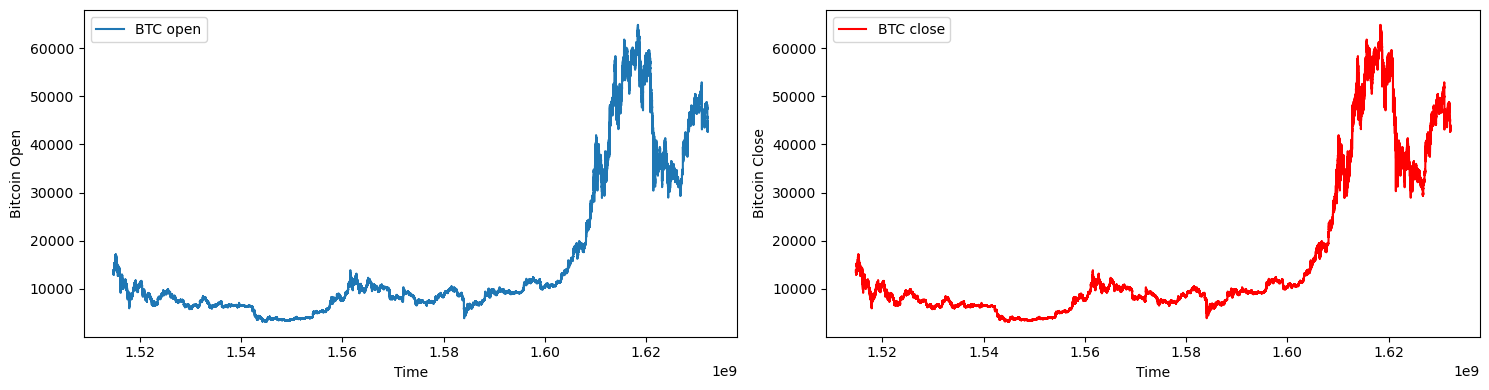

In [33]:
# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))

# fill missing values for BTC
#btc = train_data.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')

ax = f.add_subplot(121)
plt.plot(btc['Open'], label='BTC open')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Open')

ax2 = f.add_subplot(122)
ax2.plot(btc['Close'], color='red', label='BTC close')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

plt.tight_layout()
plt.show()

In [34]:
# Identifying the shape of the dataset
print(train_data.shape)

(1956282, 9)


In [35]:
# Finding the column names of Train Dataset
train_data.columns

Index(['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Target'],
      dtype='object')

In [36]:
# Identifying if any missing values are present in the dataset along with
# the data types of each column for train data
print("Train Dataset Info-",train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 149.3 MB
Train Dataset Info- None


In [37]:
# Finding the overall statistics of the train dataset
train_data.describe(include="all")

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,1956282.0,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.956282e+06,1.955978e+06
mean,1.0,1.082390e+03,1.561112e+04,1.565181e+04,1.557804e+04,1.561112e+04,9.284999e+01,1.561100e+04,-1.559993e-06
std,0.0,1.601813e+03,1.512141e+04,1.513203e+04,1.510627e+04,1.512144e+04,1.554052e+02,1.512129e+04,2.013754e-03
min,1.0,1.000000e+00,3.149657e+03,3.176910e+03,3.120000e+03,3.151545e+03,1.000000e-04,3.152326e+03,-7.255649e-02
25%,1.0,2.980000e+02,6.848250e+03,6.865382e+03,6.835622e+03,6.848072e+03,3.020642e+01,6.848265e+03,-8.163170e-04
50%,1.0,5.630000e+02,9.206021e+03,9.222400e+03,9.191175e+03,9.205980e+03,5.280397e+01,9.205946e+03,-1.916906e-05
75%,1.0,1.259000e+03,1.346695e+04,1.352072e+04,1.340000e+04,1.346706e+04,9.767651e+01,1.346745e+04,7.718871e-04
max,1.0,8.747800e+04,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,1.040500e+04,6.479982e+04,9.278919e-02


In [38]:
# Finding the overall unique values in the Target column of Train Dataset -
# 0 represents a customer who did not respond to the campaign and
# 1 represents a customer who did respond to the campaign
train_data["Target"].value_counts(sort=False)

Target
-0.014643    1
-0.015037    1
-0.010309    1
-0.008999    1
-0.008079    1
            ..
 0.002084    1
 0.003246    1
 0.003108    1
 0.002770    1
 0.002726    1
Name: count, Length: 1955977, dtype: int64

In [39]:
print("Checking for missing values in Train Data: \n",train_data.isnull().sum())

Checking for missing values in Train Data: 
 Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64


In [40]:
train_data = train_data.dropna(axis=0)

#### EDA:

#### Univariate Analysis:

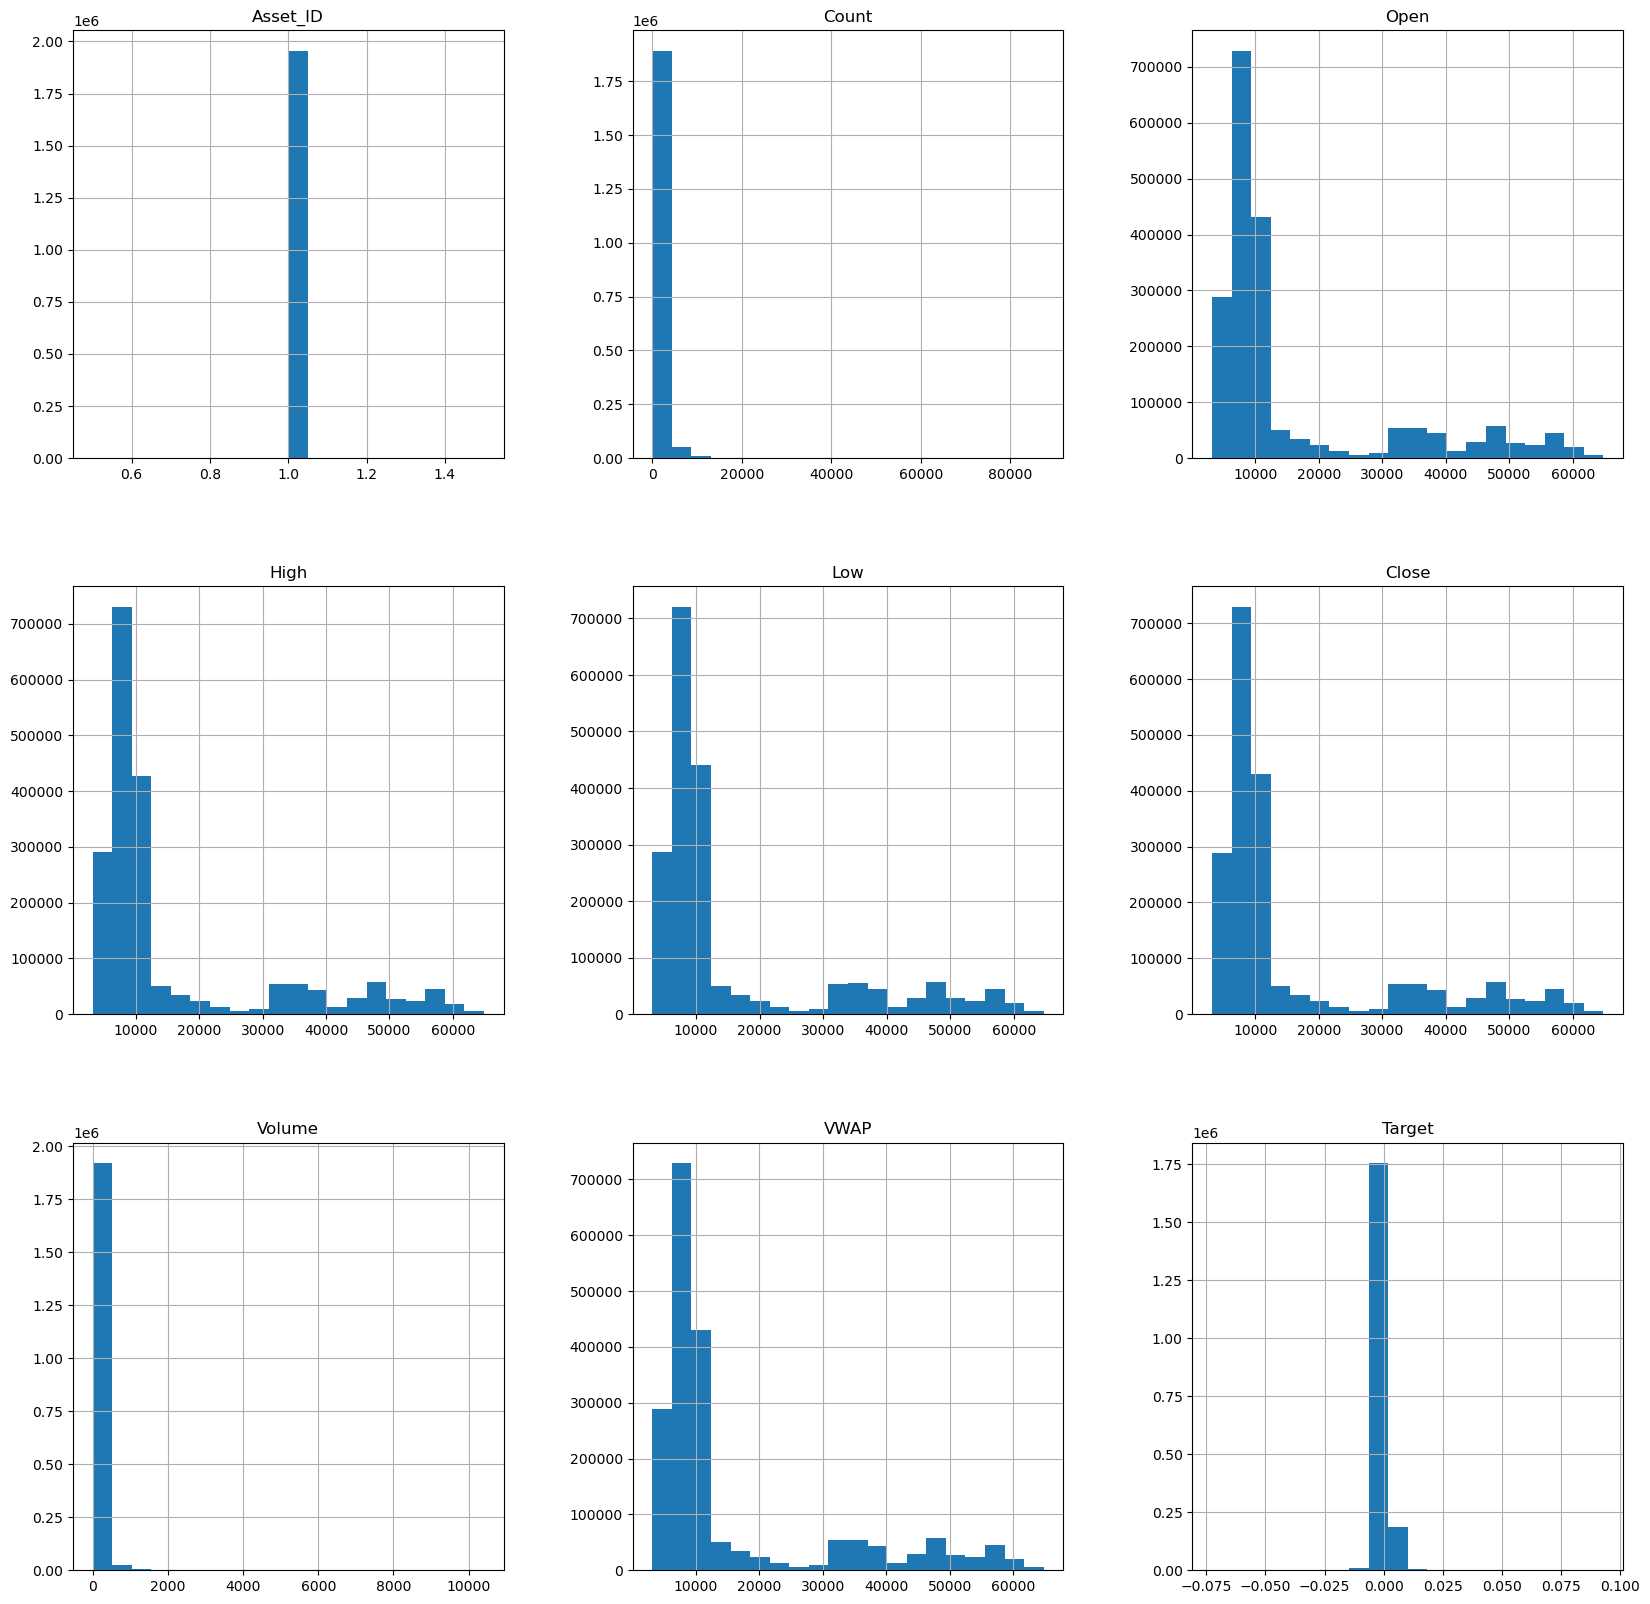

In [41]:
#sns.histplot(data = train_data , bins=20)
train_data.hist( bins = 20 , figsize = ( 20 , 20 ) )
plt.show()

#### Bivariate- Analysis:

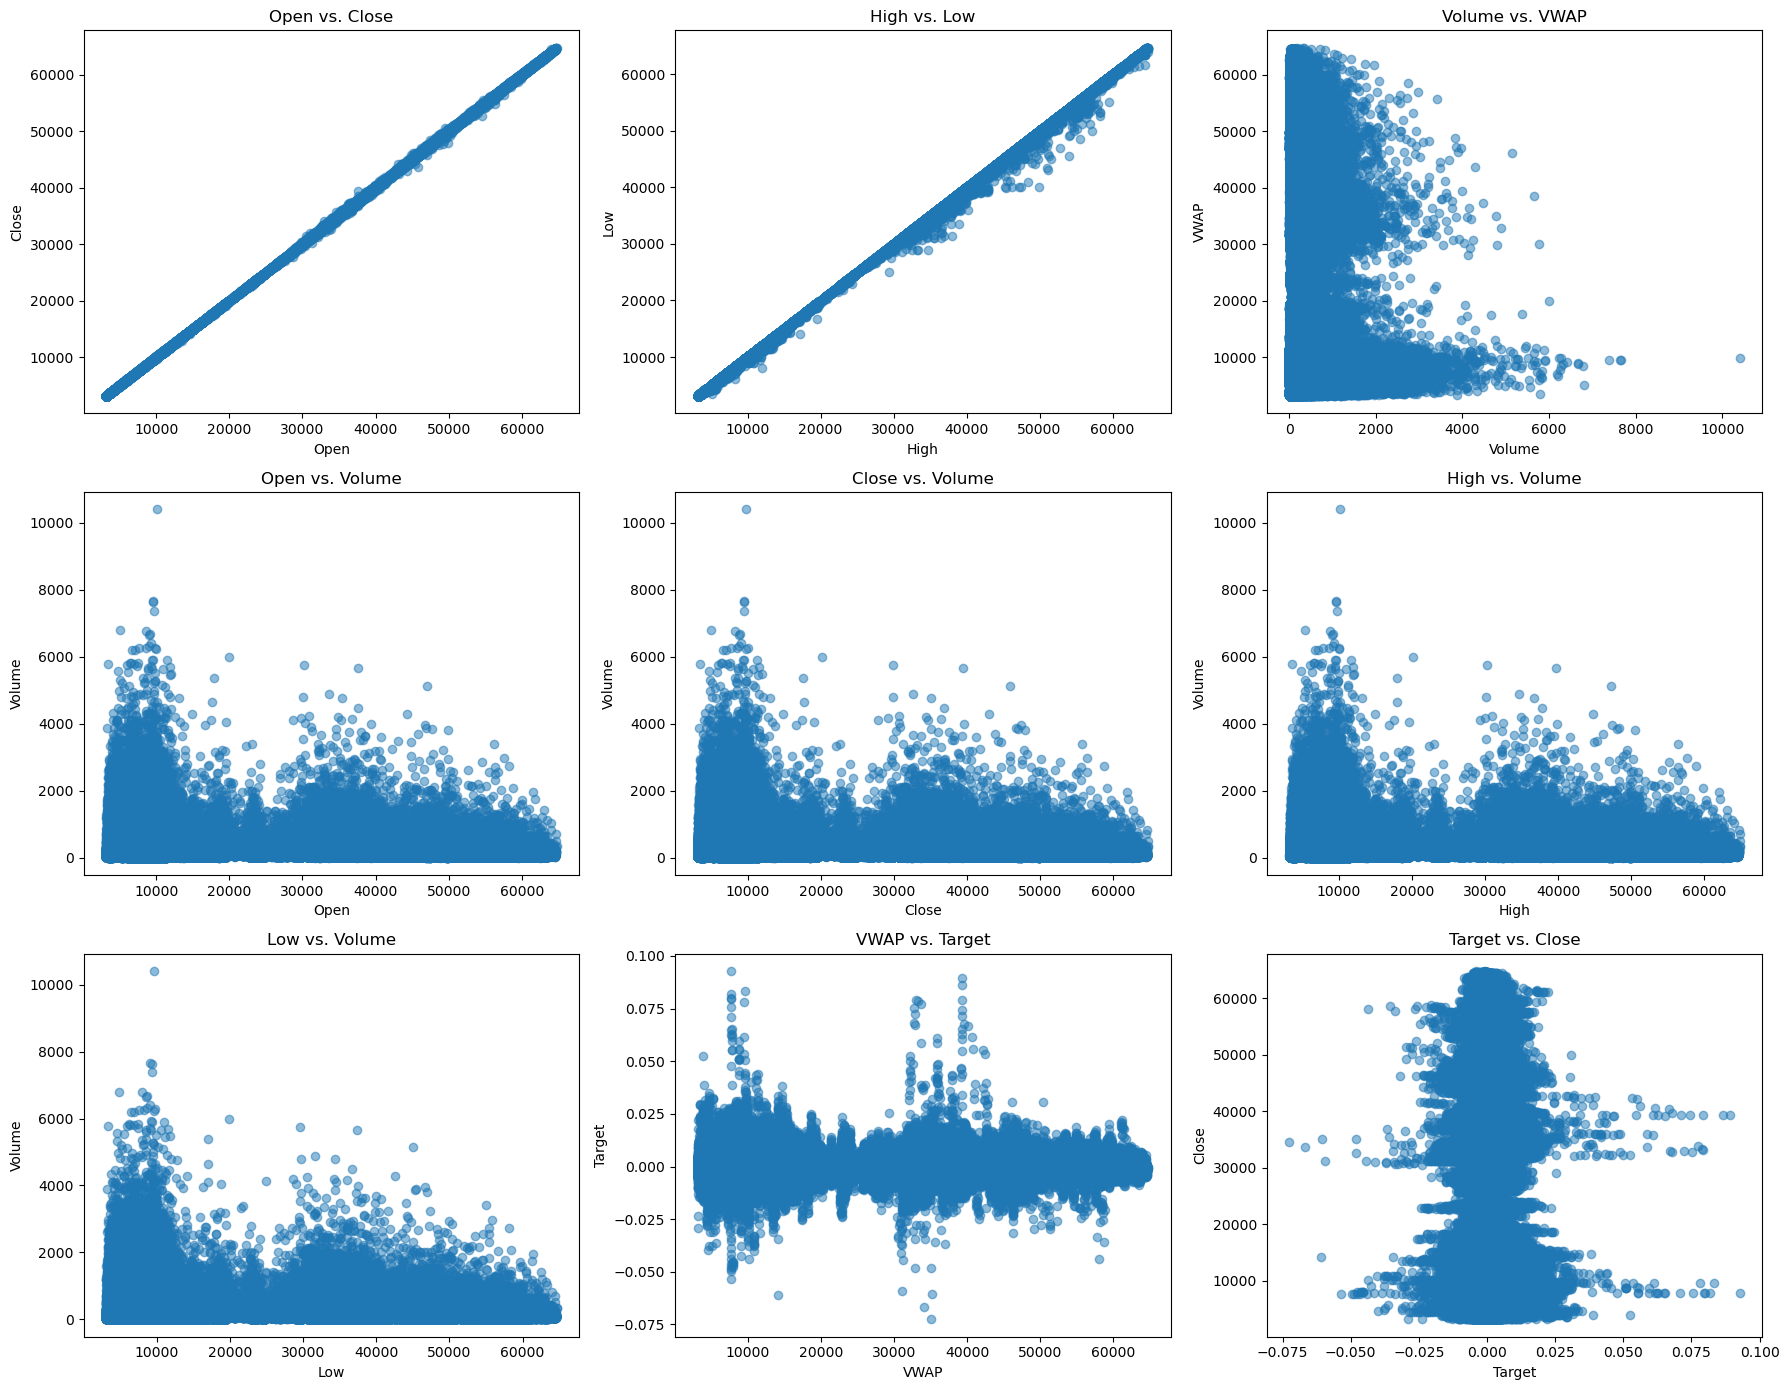

In [42]:
plt.figure(figsize=(18, 14))

# Open vs. Close
plt.subplot(3, 3, 1)
plt.scatter(train_data['Open'], train_data['Close'], alpha=0.5)
plt.title('Open vs. Close')
plt.xlabel('Open')
plt.ylabel('Close')

# High vs. Low
plt.subplot(3, 3, 2)
plt.scatter(train_data['High'], train_data['Low'], alpha=0.5)
plt.title('High vs. Low')
plt.xlabel('High')
plt.ylabel('Low')

# Volume vs. VWAP
plt.subplot(3, 3, 3)
plt.scatter(train_data['Volume'], train_data['VWAP'], alpha=0.5)
plt.title('Volume vs. VWAP')
plt.xlabel('Volume')
plt.ylabel('VWAP')

# Open vs. Volume
plt.subplot(3, 3, 4)
plt.scatter(train_data['Open'], train_data['Volume'], alpha=0.5)
plt.title('Open vs. Volume')
plt.xlabel('Open')
plt.ylabel('Volume')

# Close vs. Volume
plt.subplot(3, 3, 5)
plt.scatter(train_data['Close'], train_data['Volume'], alpha=0.5)
plt.title('Close vs. Volume')
plt.xlabel('Close')
plt.ylabel('Volume')

# High vs. Volume
plt.subplot(3, 3, 6)
plt.scatter(train_data['High'], train_data['Volume'], alpha=0.5)
plt.title('High vs. Volume')
plt.xlabel('High')
plt.ylabel('Volume')

# Low vs. Volume
plt.subplot(3, 3, 7)
plt.scatter(train_data['Low'], train_data['Volume'], alpha=0.5)
plt.title('Low vs. Volume')
plt.xlabel('Low')
plt.ylabel('Volume')

# VWAP vs. Target
plt.subplot(3, 3, 8)
plt.scatter(train_data['VWAP'], train_data['Target'], alpha=0.5)
plt.title('VWAP vs. Target')
plt.xlabel('VWAP')
plt.ylabel('Target')

# Target vs. Close
plt.subplot(3, 3, 9)
plt.scatter(train_data['Target'], train_data['Close'], alpha=0.5)
plt.title('Target vs. Close')
plt.xlabel('Target')
plt.ylabel('Close')

plt.tight_layout()
plt.show()


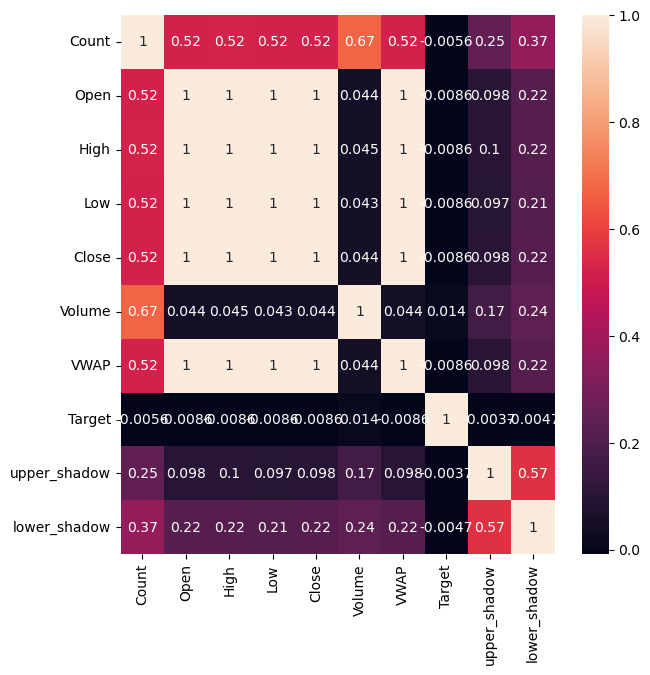

In [91]:
plt.figure( figsize = ( 7, 7 ) )
matrix = train_data.loc[:, train_data.columns != 'Asset_ID'].corr(method='pearson')
#sns.heatmap(matrix, annot=True)
#
#Pearson’s Correlations
sns.heatmap(matrix, annot=True)
#
plt.show()

In [44]:
numerical_columns = [ 'Count','Open','High','Low', 'Close', 'Volume', 'VWAP' ]

target_column     = "Target"

working_columns   = numerical_columns

print("Target Column-",target_column)
print("\n")
print("Working Column-",working_columns)

Target Column- Target


Working Column- ['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']


In [45]:
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

# Creating features to calculate upper shadow and lower shadow
train_data['upper_shadow'] = upper_shadow(train_data)
train_data['lower_shadow'] = lower_shadow(train_data)

C:\Users\Faheem\AppData\Local\Temp\ipykernel_31292\4218962908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['upper_shadow'] = upper_shadow(train_data)
C:\Users\Faheem\AppData\Local\Temp\ipykernel_31292\4218962908.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['lower_shadow'] = lower_shadow(train_data)


In [46]:
# Updating the working_columns and numerical_columns
working_columns.append('upper_shadow')
working_columns.append('lower_shadow')
print(working_columns)

['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'upper_shadow', 'lower_shadow']


In [47]:
X = train_data[working_columns]
y = train_data[target_column]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (1955978, 9)
Shape of y: (1955978,)


Feature: Low            , Score: 95.06270
Feature: Volume         , Score: 79.75863
Feature: upper_shadow   , Score: 76.46241
Feature: VWAP           , Score: 72.74732
Feature: High           , Score: 62.38208
Feature: Close          , Score: 45.43334
Feature: lower_shadow   , Score: 31.83850
Feature: Count          , Score: 17.56772
Feature: Open           , Score: 16.55053


C:\Users\Faheem\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


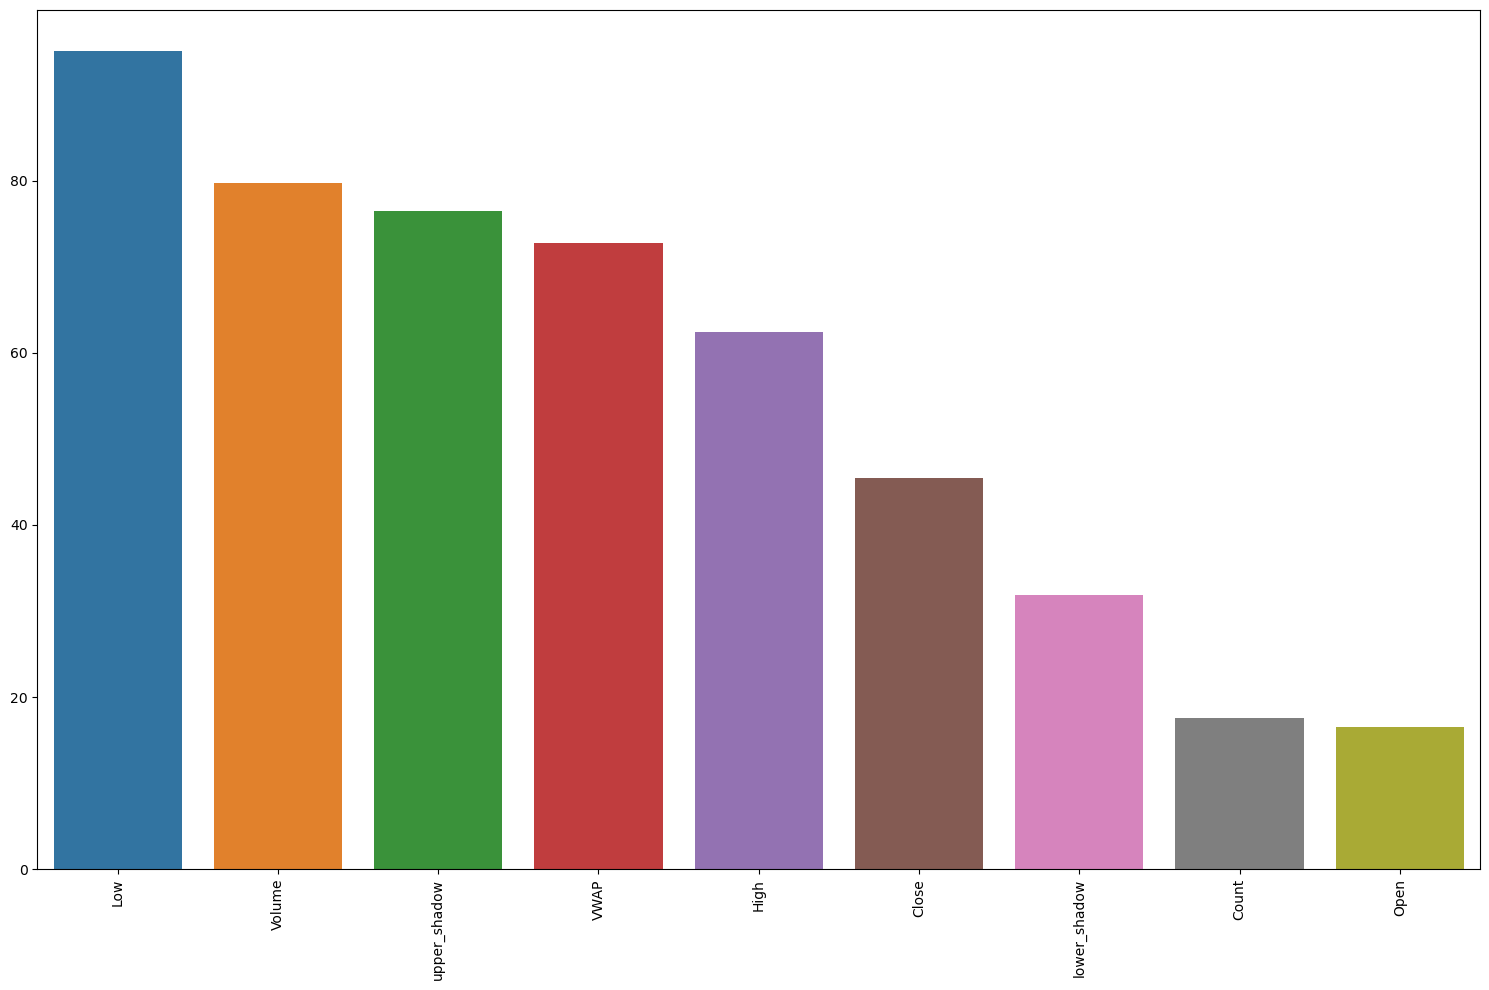

In [48]:
# Finding the importance of features
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=1000, n_features=9, n_informative=9, random_state=1)
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)

# get importance
importance = model.coef_

## summarize feature importance
importance_values = []
for i,v in enumerate(importance):
    importance_values.append([i,v])
importance_values.sort(key = lambda x: x[1],reverse=True)
for i,v in importance_values:
    print('Feature: %-15s, Score: %.5f' % (working_columns[i],v))
## plot feature importance
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot( y = [ value for x,value in importance_values ] ,
             x = [ working_columns[x] for x,value in importance_values ] )
plt.tight_layout()

In [49]:
X = train_data[working_columns]
y = train_data[target_column]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape: ", y_test.shape)

Shape of X: (1955978, 9)
Shape of y: (1955978,)
X_train.shape:  (1564782, 9)
X_test.shape:  (391196, 9)
y_train.shape:  (1564782,)
y_test.shape:  (391196,)


In [50]:
# Create numerical pipeline to transform numerical values
numerical_list_columns = list(working_columns)

numerical_pipeline = Pipeline([('missing',SimpleImputer(strategy='mean')),('scaler', StandardScaler())])

pipeline_total = ColumnTransformer( [ ("numerical", numerical_pipeline, numerical_list_columns) ] )

In [51]:
# Transformed dataset after creating pipelines
pipeline_total.fit(X_train)
X_train = pipeline_total.transform(X_train)
X_test = pipeline_total.transform(X_test)
print(f"New Transformed Shape of X_Train: {X_train.shape}")
print(f"New Transformed Shape of X_test: {X_test.shape}")

New Transformed Shape of X_Train: (1564782, 9)
New Transformed Shape of X_test: (391196, 9)


In [52]:
# Different Model Metrics
def model_eval_scores(y_test,y_pred):
    #mean_squared_error , mean_absolute_error , r2_score
    print( "Mean Squared  Error : ",f"{ mean_squared_error( y_test  , y_pred ) }" )
    print( "Mean Absolute Error : ",f"{ mean_absolute_error( y_test , y_pred ) }" )
    print( "R2 Score            : ",f"{ r2_score( y_test , y_pred ) }" )
    return mean_squared_error( y_test , y_pred ) , r2_score( y_test , y_pred )

In [53]:
mean_s_error = []
R2_score = []
models = []

In [54]:
# Saving results
def update_scores( mean_s_error_v , R2_score_v , model ):
  if model in models:
    index = models.index( model )
    mean_s_error[index] = mean_s_error_v
    R2_score[index]     = R2_score_v
  else:
    models.append( model )
    mean_s_error.append( mean_s_error_v )
    R2_score.append( R2_score_v )

In [55]:
# Displaying Results
def view_scores():
  print("The scores are:\n")
  t = PrettyTable()
  t.add_column('Model', models)
  t.add_column('Mean Squared  Error', mean_s_error)
  t.add_column('R2 Score', R2_score)
  print(t)

# 1. Linear Regresion

In [56]:
linear_regression_predictor = LinearRegression()
linear_regression_predictor.fit(X_train,y_train)
y_pred_linear_regression = linear_regression_predictor.predict(X_test)

In [61]:
# Evaluation metrics for Decision Tree
MSE_eval_score_linear_regression , R2_eval_score_linear_regression = model_eval_scores(y_test,y_pred_linear_regression)

Mean Squared  Error :  4.077755929909384e-06
Mean Absolute Error :  0.0012380808879060797
R2 Score            :  0.0010677655595967561


In [62]:
print(y_test.shape)
print(y_pred_linear_regression.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [63]:
# Appending the Model and Validation Score in a stored list
update_scores(MSE_eval_score_linear_regression,R2_eval_score_linear_regression,'LinearRegression')

In [64]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+------------------+-----------------------+-----------------------+
|      Model       |  Mean Squared  Error  |        R2 Score       |
+------------------+-----------------------+-----------------------+
| LinearRegression | 4.077755929909384e-06 | 0.0010677655595967561 |
+------------------+-----------------------+-----------------------+


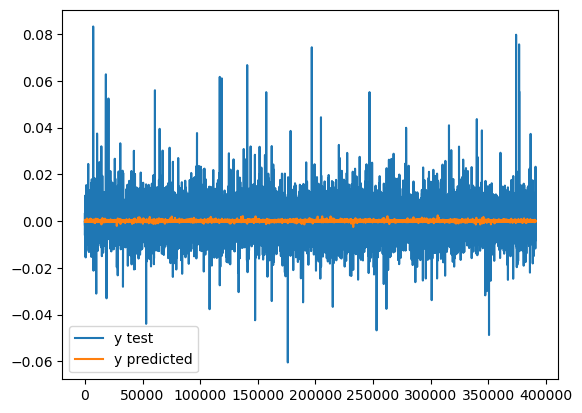

In [65]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_linear_regression , label = "y predicted" )
plt.legend() 
plt.show()

# 2. Decision Tree

In [66]:
decision_tree_regressor = DecisionTreeRegressor(random_state=0)
decision_tree_regressor.fit(X_train,y_train)
y_pred_decision_tree_regressor = decision_tree_regressor.predict(X_test)

In [67]:
# Evaluation metrics for Decision Tree
MSE_eval_score_decision_tree_regressor ,R2_eval_score_decision_tree_regressor = model_eval_scores(y_test,y_pred_decision_tree_regressor)

Mean Squared  Error :  7.946220155825404e-06
Mean Absolute Error :  0.0017924335129276458
R2 Score            :  -0.9465940561553996


In [68]:
print(y_test.shape)
print(y_pred_decision_tree_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [69]:
# Appending the Model and Validation Score in a stored list
update_scores(MSE_eval_score_decision_tree_regressor,R2_eval_score_decision_tree_regressor,'DecisionTree')

In [70]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+------------------+-----------------------+-----------------------+
|      Model       |  Mean Squared  Error  |        R2 Score       |
+------------------+-----------------------+-----------------------+
| LinearRegression | 4.077755929909384e-06 | 0.0010677655595967561 |
|   DecisionTree   | 7.946220155825404e-06 |  -0.9465940561553996  |
+------------------+-----------------------+-----------------------+


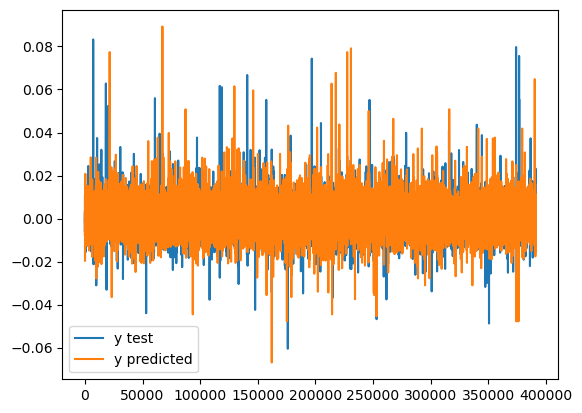

In [71]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_decision_tree_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 3. Random Forest 

In [72]:
random_forest = RandomForestRegressor(max_depth=2 , random_state=3)
random_forest.fit(X_train,y_train)
y_pred_randomforest_regressor = random_forest.predict(X_test)

In [73]:
# Evaluation metrics for Random Forest
MSE_eval_score_randomforest_regressor , R2_eval_score_randomforest_regressor = model_eval_scores(y_test,y_pred_randomforest_regressor)

Mean Squared  Error :  4.071814065767409e-06
Mean Absolute Error :  0.001238530056171291
R2 Score            :  0.002523350377841793


In [74]:
print(y_test.shape)
print(y_pred_randomforest_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [75]:
# Appending the Model and Validation Score in a stored list
update_scores(MSE_eval_score_randomforest_regressor,R2_eval_score_randomforest_regressor,'RandomForest')

In [76]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+------------------+-----------------------+-----------------------+
|      Model       |  Mean Squared  Error  |        R2 Score       |
+------------------+-----------------------+-----------------------+
| LinearRegression | 4.077755929909384e-06 | 0.0010677655595967561 |
|   DecisionTree   | 7.946220155825404e-06 |  -0.9465940561553996  |
|   RandomForest   | 4.071814065767409e-06 |  0.002523350377841793 |
+------------------+-----------------------+-----------------------+


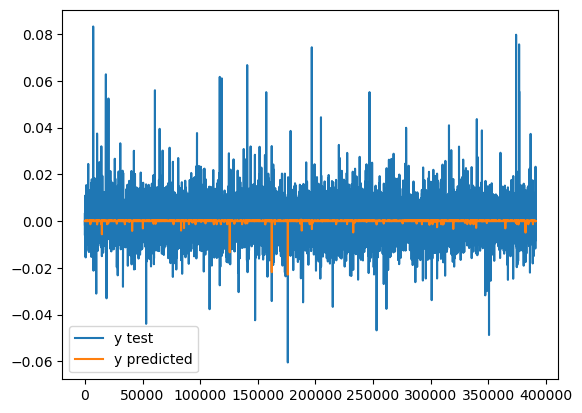

In [77]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_randomforest_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 4. KNeighbors Regressor 

In [78]:
kneigh = KNeighborsRegressor(n_neighbors = 7)
kneigh.fit(X_train,y_train)
y_pred_kneigh_regressor = kneigh.predict(X_test)

In [85]:
# Evaluation metrics for Random Forest
MSE_eval_score_kneigh_regressor , R2_eval_score_kneigh_regressor = model_eval_scores(y_test,y_pred_kneigh_regressor)

Mean Squared  Error :  4.528346542971248e-06
Mean Absolute Error :  0.0013481201524392099
R2 Score            :  -0.10931389917475176


In [86]:
print(y_test.shape)
print(y_pred_kneigh_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [87]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_kneigh_regressor , R2_eval_score_kneigh_regressor ,'KNeighbors')

In [88]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+------------------+-----------------------+-----------------------+
|      Model       |  Mean Squared  Error  |        R2 Score       |
+------------------+-----------------------+-----------------------+
| LinearRegression | 4.077755929909384e-06 | 0.0010677655595967561 |
|   DecisionTree   | 7.946220155825404e-06 |  -0.9465940561553996  |
|   RandomForest   | 4.071814065767409e-06 |  0.002523350377841793 |
|    KNeighbors    | 4.528346542971248e-06 |  -0.10931389917475176 |
+------------------+-----------------------+-----------------------+


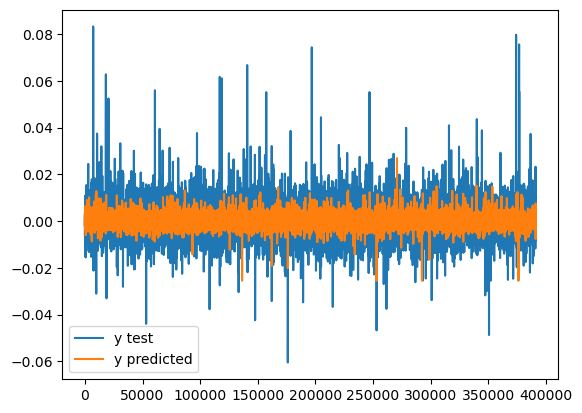

In [89]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_kneigh_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 5. Adaboost

In [90]:
adaboostRegressor = AdaBoostRegressor(random_state=0, n_estimators=100)
adaboostRegressor.fit(X_train,y_train)
y_pred_adaboost_regressor = adaboostRegressor.predict(X_test)

In [92]:
# Evaluation metrics for Adaboost Regressor
MSE_eval_score_adaboost_regressor , R2_eval_score_adaboost_regressor = model_eval_scores(y_test,y_pred_adaboost_regressor)

Mean Squared  Error :  1.893919327645558e-05
Mean Absolute Error :  0.0022705686109470145
R2 Score            :  -3.639554446940342


In [93]:
print(y_test.shape)
print(y_pred_adaboost_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [94]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_adaboost_regressor , R2_eval_score_adaboost_regressor ,'Adaboost_Regressor')

In [95]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+--------------------+-----------------------+-----------------------+
|       Model        |  Mean Squared  Error  |        R2 Score       |
+--------------------+-----------------------+-----------------------+
|  LinearRegression  | 4.077755929909384e-06 | 0.0010677655595967561 |
|    DecisionTree    | 7.946220155825404e-06 |  -0.9465940561553996  |
|    RandomForest    | 4.071814065767409e-06 |  0.002523350377841793 |
|     KNeighbors     | 4.528346542971248e-06 |  -0.10931389917475176 |
| Adaboost_Regressor | 1.893919327645558e-05 |   -3.639554446940342  |
+--------------------+-----------------------+-----------------------+


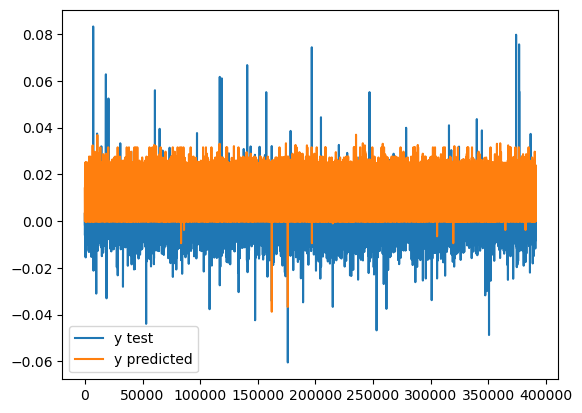

In [96]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_adaboost_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 6. Gradient Boosting

In [97]:
Gboost_regressor = GradientBoostingRegressor()
Gboost_regressor.fit(X_train,y_train)
y_pred_Gboost_regressor = Gboost_regressor.predict(X_test)

In [69]:
# Evaluation metrics for Adaboost Regressor
MSE_eval_score_Gboost_regressor , R2_eval_score_Gboost_regressor = model_eval_scores(y_test,y_pred_Gboost_regressor)

Mean Squared  Error :  4.051445837256448e-06
Mean Absolute Error :  0.0012372303345797482
R2 Score            :  0.007512977115629149


In [70]:
print(y_test.shape)
print(y_pred_Gboost_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [71]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_Gboost_regressor , R2_eval_score_Gboost_regressor ,'Gradient_boost_Regressor')

In [72]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+--------------------------+-----------------------+-----------------------+
|          Model           |  Mean Squared  Error  |        R2 Score       |
+--------------------------+-----------------------+-----------------------+
|     LinearRegression     | 4.077768814176103e-06 | 0.0010646092869888157 |
|       DecisionTree       | 7.946220155825404e-06 |  -0.9465940561553996  |
|       GridSearchCV       | 4.076280981000996e-06 | 0.0014290853722748187 |
|       RandomForest       | 4.071814065767409e-06 |  0.002523350377841793 |
|        KNeighbors        | 4.528346542971248e-06 |  -0.10931389917475176 |
|    Adaboost_Regressor    | 1.893919327645558e-05 |   -3.639554446940342  |
| Gradient_boost_Regressor | 4.051445837256448e-06 |  0.007512977115629149 |
+--------------------------+-----------------------+-----------------------+


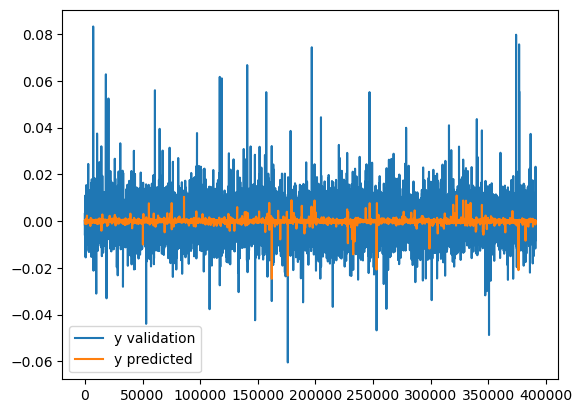

In [73]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_Gboost_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 7. XG Boost

In [74]:
XGboostRegressor = xgb.XGBRegressor()
XGboostRegressor.fit(X_train,y_train)
y_pred_XGboost_regressor = XGboostRegressor.predict(X_test)

In [75]:
# Evaluation metrics for Adaboost Regressor
MSE_eval_score_XGboost_regressor , R2_eval_score_XGboost_regressor = model_eval_scores(y_test,y_pred_XGboost_regressor)

Mean Squared  Error :  4.012689507663918e-06
Mean Absolute Error :  0.0012352461067571604
R2 Score            :  0.017007156655559297


In [76]:
print(y_test.shape)
print(y_pred_XGboost_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [77]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_XGboost_regressor , R2_eval_score_XGboost_regressor ,'XGboost_Regressor')

In [78]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+--------------------------+-----------------------+-----------------------+
|          Model           |  Mean Squared  Error  |        R2 Score       |
+--------------------------+-----------------------+-----------------------+
|     LinearRegression     | 4.077768814176103e-06 | 0.0010646092869888157 |
|       DecisionTree       | 7.946220155825404e-06 |  -0.9465940561553996  |
|       GridSearchCV       | 4.076280981000996e-06 | 0.0014290853722748187 |
|       RandomForest       | 4.071814065767409e-06 |  0.002523350377841793 |
|        KNeighbors        | 4.528346542971248e-06 |  -0.10931389917475176 |
|    Adaboost_Regressor    | 1.893919327645558e-05 |   -3.639554446940342  |
| Gradient_boost_Regressor | 4.051445837256448e-06 |  0.007512977115629149 |
|    XGboost_Regressor     | 4.012689507663918e-06 |  0.017007156655559297 |
+--------------------------+-----------------------+-----------------------+


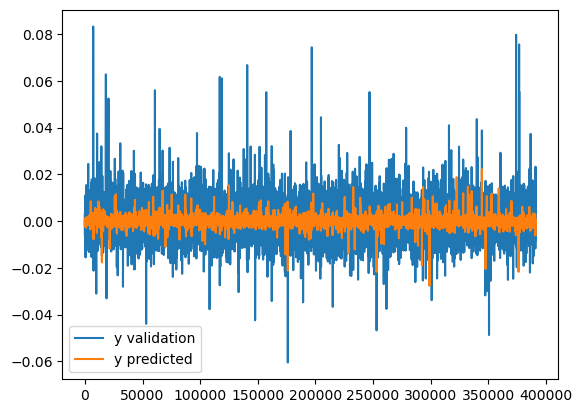

In [79]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_XGboost_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 8. Light GBM 

In [80]:
#######
# laoding model
LGBM_regressor = LGBMRegressor()
LGBM_regressor.fit(X_train,y_train)
y_pred_LGBM_regressor = LGBM_regressor.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 1564782, number of used features: 9
[LightGBM] [Info] Start training from score -0.000003


In [81]:
# Evaluation metrics for Adaboost Regressor
MSE_eval_score_LGBM_regressor , R2_eval_score_LGBM_regressor = model_eval_scores(y_test,y_pred_LGBM_regressor)

Mean Squared  Error :  4.030760195289275e-06
Mean Absolute Error :  0.0012357634060418394
R2 Score            :  0.012580360967502258


In [82]:
print(y_test.shape)
print(y_pred_LGBM_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [83]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_LGBM_regressor , R2_eval_score_LGBM_regressor ,'LGBM_Regressor')

In [84]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+--------------------------+-----------------------+-----------------------+
|          Model           |  Mean Squared  Error  |        R2 Score       |
+--------------------------+-----------------------+-----------------------+
|     LinearRegression     | 4.077768814176103e-06 | 0.0010646092869888157 |
|       DecisionTree       | 7.946220155825404e-06 |  -0.9465940561553996  |
|       GridSearchCV       | 4.076280981000996e-06 | 0.0014290853722748187 |
|       RandomForest       | 4.071814065767409e-06 |  0.002523350377841793 |
|        KNeighbors        | 4.528346542971248e-06 |  -0.10931389917475176 |
|    Adaboost_Regressor    | 1.893919327645558e-05 |   -3.639554446940342  |
| Gradient_boost_Regressor | 4.051445837256448e-06 |  0.007512977115629149 |
|    XGboost_Regressor     | 4.012689507663918e-06 |  0.017007156655559297 |
|      LGBM_Regressor      | 4.030760195289275e-06 |  0.012580360967502258 |
+--------------------------+-----------------------+-------

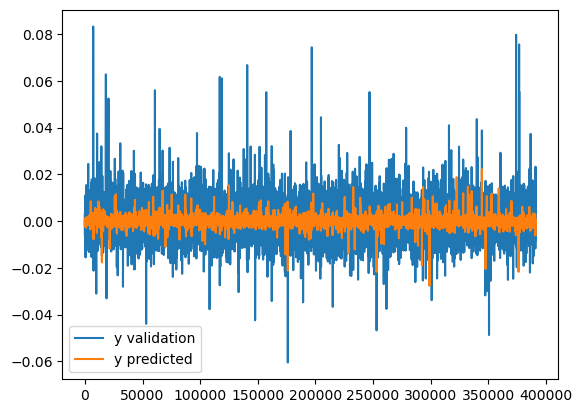

In [85]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_XGboost_regressor , label = "y predicted" )
plt.legend() 
plt.show()

# 9. CatBoost regressor

In [86]:
#######
# laoding model
CATBOOST_regressor = cb.CatBoostRegressor(loss_function="RMSE")
CATBOOST_regressor.fit(X_train,y_train)
y_pred_CATBOOST_regressor = CATBOOST_regressor.predict(X_test)

Learning rate set to 0.130889
0:	learn: 0.0020117	total: 276ms	remaining: 4m 35s
1:	learn: 0.0020113	total: 387ms	remaining: 3m 13s
2:	learn: 0.0020109	total: 478ms	remaining: 2m 38s
3:	learn: 0.0020107	total: 573ms	remaining: 2m 22s
4:	learn: 0.0020103	total: 659ms	remaining: 2m 11s
5:	learn: 0.0020100	total: 746ms	remaining: 2m 3s
6:	learn: 0.0020096	total: 853ms	remaining: 2m 1s
7:	learn: 0.0020092	total: 944ms	remaining: 1m 57s
8:	learn: 0.0020090	total: 1.06s	remaining: 1m 56s
9:	learn: 0.0020085	total: 1.16s	remaining: 1m 54s
10:	learn: 0.0020082	total: 1.25s	remaining: 1m 52s
11:	learn: 0.0020080	total: 1.36s	remaining: 1m 52s
12:	learn: 0.0020078	total: 1.46s	remaining: 1m 50s
13:	learn: 0.0020076	total: 1.57s	remaining: 1m 50s
14:	learn: 0.0020075	total: 1.68s	remaining: 1m 50s
15:	learn: 0.0020074	total: 1.78s	remaining: 1m 49s
16:	learn: 0.0020071	total: 1.89s	remaining: 1m 49s
17:	learn: 0.0020069	total: 1.99s	remaining: 1m 48s
18:	learn: 0.0020067	total: 2.12s	remaining: 1

158:	learn: 0.0019924	total: 19.4s	remaining: 1m 42s
159:	learn: 0.0019924	total: 19.5s	remaining: 1m 42s
160:	learn: 0.0019922	total: 19.6s	remaining: 1m 42s
161:	learn: 0.0019922	total: 19.7s	remaining: 1m 42s
162:	learn: 0.0019921	total: 19.8s	remaining: 1m 41s
163:	learn: 0.0019921	total: 20s	remaining: 1m 41s
164:	learn: 0.0019918	total: 20.1s	remaining: 1m 41s
165:	learn: 0.0019918	total: 20.2s	remaining: 1m 41s
166:	learn: 0.0019917	total: 20.3s	remaining: 1m 41s
167:	learn: 0.0019916	total: 20.4s	remaining: 1m 41s
168:	learn: 0.0019915	total: 20.5s	remaining: 1m 41s
169:	learn: 0.0019915	total: 20.6s	remaining: 1m 40s
170:	learn: 0.0019914	total: 20.8s	remaining: 1m 40s
171:	learn: 0.0019913	total: 20.9s	remaining: 1m 40s
172:	learn: 0.0019913	total: 21s	remaining: 1m 40s
173:	learn: 0.0019912	total: 21.1s	remaining: 1m 40s
174:	learn: 0.0019912	total: 21.3s	remaining: 1m 40s
175:	learn: 0.0019911	total: 21.4s	remaining: 1m 40s
176:	learn: 0.0019911	total: 21.5s	remaining: 1m 3

314:	learn: 0.0019829	total: 38.8s	remaining: 1m 24s
315:	learn: 0.0019829	total: 38.9s	remaining: 1m 24s
316:	learn: 0.0019828	total: 39.1s	remaining: 1m 24s
317:	learn: 0.0019828	total: 39.2s	remaining: 1m 24s
318:	learn: 0.0019827	total: 39.3s	remaining: 1m 23s
319:	learn: 0.0019826	total: 39.4s	remaining: 1m 23s
320:	learn: 0.0019826	total: 39.6s	remaining: 1m 23s
321:	learn: 0.0019825	total: 39.7s	remaining: 1m 23s
322:	learn: 0.0019825	total: 39.8s	remaining: 1m 23s
323:	learn: 0.0019824	total: 39.9s	remaining: 1m 23s
324:	learn: 0.0019824	total: 40.1s	remaining: 1m 23s
325:	learn: 0.0019822	total: 40.2s	remaining: 1m 23s
326:	learn: 0.0019822	total: 40.3s	remaining: 1m 22s
327:	learn: 0.0019822	total: 40.4s	remaining: 1m 22s
328:	learn: 0.0019821	total: 40.6s	remaining: 1m 22s
329:	learn: 0.0019821	total: 40.7s	remaining: 1m 22s
330:	learn: 0.0019820	total: 40.8s	remaining: 1m 22s
331:	learn: 0.0019820	total: 40.9s	remaining: 1m 22s
332:	learn: 0.0019819	total: 41s	remaining: 1m

470:	learn: 0.0019759	total: 1m	remaining: 1m 8s
471:	learn: 0.0019758	total: 1m 1s	remaining: 1m 8s
472:	learn: 0.0019758	total: 1m 1s	remaining: 1m 8s
473:	learn: 0.0019758	total: 1m 1s	remaining: 1m 8s
474:	learn: 0.0019758	total: 1m 1s	remaining: 1m 8s
475:	learn: 0.0019758	total: 1m 1s	remaining: 1m 8s
476:	learn: 0.0019757	total: 1m 2s	remaining: 1m 8s
477:	learn: 0.0019756	total: 1m 2s	remaining: 1m 8s
478:	learn: 0.0019756	total: 1m 2s	remaining: 1m 8s
479:	learn: 0.0019756	total: 1m 2s	remaining: 1m 8s
480:	learn: 0.0019755	total: 1m 3s	remaining: 1m 8s
481:	learn: 0.0019755	total: 1m 3s	remaining: 1m 7s
482:	learn: 0.0019755	total: 1m 3s	remaining: 1m 7s
483:	learn: 0.0019754	total: 1m 3s	remaining: 1m 7s
484:	learn: 0.0019754	total: 1m 3s	remaining: 1m 7s
485:	learn: 0.0019753	total: 1m 4s	remaining: 1m 7s
486:	learn: 0.0019753	total: 1m 4s	remaining: 1m 7s
487:	learn: 0.0019752	total: 1m 4s	remaining: 1m 7s
488:	learn: 0.0019752	total: 1m 4s	remaining: 1m 7s
489:	learn: 0.0

628:	learn: 0.0019702	total: 1m 33s	remaining: 55.1s
629:	learn: 0.0019702	total: 1m 33s	remaining: 55s
630:	learn: 0.0019702	total: 1m 33s	remaining: 54.8s
631:	learn: 0.0019702	total: 1m 33s	remaining: 54.7s
632:	learn: 0.0019701	total: 1m 34s	remaining: 54.6s
633:	learn: 0.0019701	total: 1m 34s	remaining: 54.5s
634:	learn: 0.0019701	total: 1m 34s	remaining: 54.4s
635:	learn: 0.0019700	total: 1m 34s	remaining: 54.2s
636:	learn: 0.0019700	total: 1m 35s	remaining: 54.2s
637:	learn: 0.0019700	total: 1m 35s	remaining: 54.1s
638:	learn: 0.0019700	total: 1m 35s	remaining: 54s
639:	learn: 0.0019700	total: 1m 35s	remaining: 53.8s
640:	learn: 0.0019699	total: 1m 35s	remaining: 53.7s
641:	learn: 0.0019699	total: 1m 36s	remaining: 53.6s
642:	learn: 0.0019698	total: 1m 36s	remaining: 53.5s
643:	learn: 0.0019698	total: 1m 36s	remaining: 53.3s
644:	learn: 0.0019698	total: 1m 36s	remaining: 53.2s
645:	learn: 0.0019698	total: 1m 36s	remaining: 53.1s
646:	learn: 0.0019697	total: 1m 37s	remaining: 53s

786:	learn: 0.0019653	total: 2m 6s	remaining: 34.1s
787:	learn: 0.0019653	total: 2m 6s	remaining: 34s
788:	learn: 0.0019652	total: 2m 6s	remaining: 33.8s
789:	learn: 0.0019652	total: 2m 6s	remaining: 33.7s
790:	learn: 0.0019652	total: 2m 6s	remaining: 33.5s
791:	learn: 0.0019651	total: 2m 7s	remaining: 33.4s
792:	learn: 0.0019651	total: 2m 7s	remaining: 33.2s
793:	learn: 0.0019651	total: 2m 7s	remaining: 33.1s
794:	learn: 0.0019650	total: 2m 7s	remaining: 32.9s
795:	learn: 0.0019650	total: 2m 7s	remaining: 32.8s
796:	learn: 0.0019650	total: 2m 8s	remaining: 32.6s
797:	learn: 0.0019650	total: 2m 8s	remaining: 32.5s
798:	learn: 0.0019650	total: 2m 8s	remaining: 32.3s
799:	learn: 0.0019649	total: 2m 8s	remaining: 32.2s
800:	learn: 0.0019649	total: 2m 8s	remaining: 32s
801:	learn: 0.0019649	total: 2m 9s	remaining: 31.9s
802:	learn: 0.0019649	total: 2m 9s	remaining: 31.7s
803:	learn: 0.0019649	total: 2m 9s	remaining: 31.6s
804:	learn: 0.0019648	total: 2m 9s	remaining: 31.4s
805:	learn: 0.00

943:	learn: 0.0019607	total: 2m 38s	remaining: 9.39s
944:	learn: 0.0019607	total: 2m 38s	remaining: 9.23s
945:	learn: 0.0019607	total: 2m 38s	remaining: 9.06s
946:	learn: 0.0019606	total: 2m 38s	remaining: 8.9s
947:	learn: 0.0019606	total: 2m 39s	remaining: 8.73s
948:	learn: 0.0019606	total: 2m 39s	remaining: 8.56s
949:	learn: 0.0019605	total: 2m 39s	remaining: 8.4s
950:	learn: 0.0019605	total: 2m 39s	remaining: 8.23s
951:	learn: 0.0019605	total: 2m 40s	remaining: 8.07s
952:	learn: 0.0019605	total: 2m 40s	remaining: 7.9s
953:	learn: 0.0019604	total: 2m 40s	remaining: 7.73s
954:	learn: 0.0019604	total: 2m 40s	remaining: 7.57s
955:	learn: 0.0019604	total: 2m 40s	remaining: 7.4s
956:	learn: 0.0019603	total: 2m 41s	remaining: 7.23s
957:	learn: 0.0019603	total: 2m 41s	remaining: 7.07s
958:	learn: 0.0019603	total: 2m 41s	remaining: 6.9s
959:	learn: 0.0019603	total: 2m 41s	remaining: 6.73s
960:	learn: 0.0019602	total: 2m 41s	remaining: 6.57s
961:	learn: 0.0019602	total: 2m 42s	remaining: 6.4s

In [87]:
# Evaluation metrics for Adaboost Regressor
MSE_eval_score_CATBOOST_regressor , R2_eval_score_CATBOOST_regressor = model_eval_scores(y_test,y_pred_CATBOOST_regressor)

Mean Squared  Error :  4.007074174767325e-06
Mean Absolute Error :  0.001234504335636526
R2 Score            :  0.01838275076514695


In [88]:
print(y_test.shape)
print(y_pred_CATBOOST_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196,)


In [89]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_CATBOOST_regressor , R2_eval_score_CATBOOST_regressor ,'CATBOOST_Regressor')

In [90]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+--------------------------+-----------------------+-----------------------+
|          Model           |  Mean Squared  Error  |        R2 Score       |
+--------------------------+-----------------------+-----------------------+
|     LinearRegression     | 4.077768814176103e-06 | 0.0010646092869888157 |
|       DecisionTree       | 7.946220155825404e-06 |  -0.9465940561553996  |
|       GridSearchCV       | 4.076280981000996e-06 | 0.0014290853722748187 |
|       RandomForest       | 4.071814065767409e-06 |  0.002523350377841793 |
|        KNeighbors        | 4.528346542971248e-06 |  -0.10931389917475176 |
|    Adaboost_Regressor    | 1.893919327645558e-05 |   -3.639554446940342  |
| Gradient_boost_Regressor | 4.051445837256448e-06 |  0.007512977115629149 |
|    XGboost_Regressor     | 4.012689507663918e-06 |  0.017007156655559297 |
|      LGBM_Regressor      | 4.030760195289275e-06 |  0.012580360967502258 |
|    CATBOOST_Regressor    | 4.007074174767325e-06 |  0.018

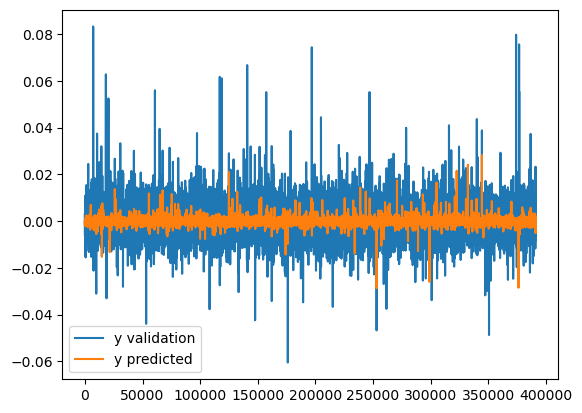

In [91]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_CATBOOST_regressor, label = "y predicted" )
plt.legend() 
plt.show()

# 10. Regression using ANN

In [53]:
def build_model():
    model=keras.Sequential([Dense(16, activation='relu'),Dense(16, activation='relu'),
                                                 Dense(1)])
    optimizer=tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae','mse'])
    return model

In [54]:
ANN_regressor = build_model()

In [56]:
ANN_regressor.fit( X_train , y_train , epochs = 20 )

Epoch 1/20
48900/48900 [==============================] - 93s 2ms/step - loss: 4.9344e-06 - mae: 0.0014 - mse: 4.9344e-06
Epoch 2/20
48900/48900 [==============================] - 93s 2ms/step - loss: 4.4318e-06 - mae: 0.0014 - mse: 4.4318e-06
Epoch 3/20
48900/48900 [==============================] - 88s 2ms/step - loss: 4.3910e-06 - mae: 0.0013 - mse: 4.3910e-06
Epoch 4/20
48900/48900 [==============================] - 97s 2ms/step - loss: 4.3733e-06 - mae: 0.0013 - mse: 4.3733e-06
Epoch 5/20
48900/48900 [==============================] - 92s 2ms/step - loss: 4.3695e-06 - mae: 0.0013 - mse: 4.3695e-06
Epoch 6/20
48900/48900 [==============================] - 91s 2ms/step - loss: 4.3690e-06 - mae: 0.0013 - mse: 4.3690e-06
Epoch 7/20
48900/48900 [==============================] - 95s 2ms/step - loss: 4.3633e-06 - mae: 0.0013 - mse: 4.3633e-06
Epoch 8/20
48900/48900 [==============================] - 90s 2ms/step - loss: 4.3644e-06 - mae: 0.0013 - mse: 4.3644e-06
Epoch 9/20
48900/48900 [

In [57]:
y_pred_ANN_regressor = ANN_regressor.predict(X_test)

12225/12225 [==============================] - 18s 1ms/step


In [58]:
# Evaluation metrics for ANN Regressor
MSE_eval_score_ANN_regressor , R2_eval_score_ANN_regressor = model_eval_scores(y_test,y_pred_ANN_regressor)

Mean Squared  Error :  4.181315939119983e-06
Mean Absolute Error :  0.0012789498539906726
R2 Score            :  -0.024301440733657698


In [59]:
print(y_test.shape)
print(y_pred_ANN_regressor.shape)
x = np.arange(len(y_test))

(391196,)
(391196, 1)


In [60]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_ANN_regressor , R2_eval_score_ANN_regressor ,'ANN_Regressor')

In [61]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+---------------+-----------------------+-----------------------+
|     Model     |  Mean Squared  Error  |        R2 Score       |
+---------------+-----------------------+-----------------------+
| ANN_Regressor | 4.181315939119983e-06 | -0.024301440733657698 |
+---------------+-----------------------+-----------------------+


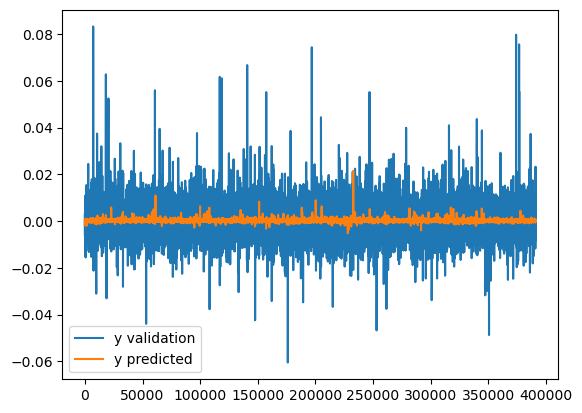

In [62]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_ANN_regressor, label = "y predicted" )
plt.legend() 
plt.show()

# 11. Recurrent Neural Network

In [86]:
# Reshape the input data for RNN
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define a function to build the RNN model
def build_rnn_model(input_shape):
    model = keras.Sequential([
        keras.layers.SimpleRNN(units=64, input_shape=input_shape, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='relu')  # regression
    ])
    return model

In [87]:
# Build the RNN model
RNN_model = build_rnn_model(input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]))

In [88]:
# Compile the model
RNN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
RNN_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_29 (Dense)            (None, 512)               33280     
                                                                 
 dense_30 (Dense)            (None, 512)               262656    
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dense_32 (Dense)            (None, 128)               32896     
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 32)              

In [89]:
RNN_model.fit( X_train_rnn , y_train , epochs = 20 )

Epoch 1/20
48900/48900 [==============================] - 322s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 2/20
48900/48900 [==============================] - 342s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 3/20
48900/48900 [==============================] - 343s 7ms/step - loss: 4.0484e-06 - mse: 4.0484e-06 - mae: 0.0012
Epoch 4/20
48900/48900 [==============================] - 322s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 5/20
48900/48900 [==============================] - 326s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 6/20
48900/48900 [==============================] - 318s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 7/20
48900/48900 [==============================] - 326s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 8/20
48900/48900 [==============================] - 321s 7ms/step - loss: 4.0485e-06 - mse: 4.0485e-06 - mae: 0.0012
Epoch 9/20
48900

In [ ]:
y_pred_RNN_model = RNN_model.predict(X_test)

12225/12225 [==============================] - 25s 2ms/step


In [43]:
# Evaluation metrics for RNN Regressor
MSE_eval_score_RNN , R2_eval_score_RNN = model_eval_scores(y_test,y_pred_RNN_model)

Mean Squared  Error :  4.082143746729277e-06
Mean Absolute Error :  0.0012387662353933243
R2 Score            :  -7.122622911248655e-06


In [44]:
print(y_test.shape)
print(y_pred_RNN_model.shape)
x = np.arange(len(y_test))

(391196,)
(391196, 1)


In [47]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_RNN , R2_eval_score_RNN ,'RNN_Regressor')

In [48]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+---------------+-----------------------+------------------------+
|     Model     |  Mean Squared  Error  |        R2 Score        |
+---------------+-----------------------+------------------------+
| RNN_Regressor | 4.082143746729277e-06 | -7.122622911248655e-06 |
+---------------+-----------------------+------------------------+


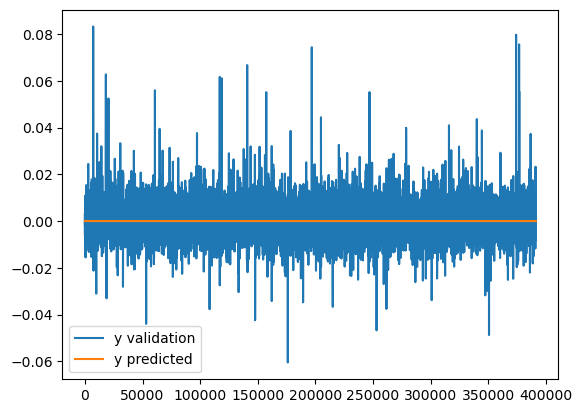

In [49]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_RNN_model, label = "y predicted" )
plt.legend() 
plt.show()

# 12. Long Short Term Memory (LSTM)

In [76]:
# Reshape the input data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

print(X_train_lstm.shape)
print(y_train.shape)
# Build the LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=50, activation='relu', input_shape=(9, 1)))
LSTM_model.add(Dense(units=1))

(1564782, 9, 1)
(1564782,)


In [77]:
# Compile the model
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
LSTM_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                10400     
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
#LSTM_model.fit( X_train , y_train )
LSTM_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
39120/39120 [==============================] - 130s 3ms/step - loss: 5.4133e-06 - val_loss: 4.2950e-06
Epoch 2/20
39120/39120 [==============================] - 129s 3ms/step - loss: 4.1909e-06 - val_loss: 4.1568e-06
Epoch 3/20
39120/39120 [==============================] - 134s 3ms/step - loss: 4.1965e-06 - val_loss: 5.6192e-06
Epoch 4/20
39120/39120 [==============================] - 123s 3ms/step - loss: 4.1912e-06 - val_loss: 4.0794e-06
Epoch 5/20
39120/39120 [==============================] - 123s 3ms/step - loss: 4.1961e-06 - val_loss: 4.0254e-06
Epoch 6/20
39120/39120 [==============================] - 123s 3ms/step - loss: 4.1943e-06 - val_loss: 4.1453e-06
Epoch 7/20
39120/39120 [==============================] - 123s 3ms/step - loss: 4.1946e-06 - val_loss: 4.0477e-06
Epoch 8/20
39120/39120 [==============================] - 125s 3ms/step - loss: 4.1958e-06 - val_loss: 4.0872e-06
Epoch 9/20
39120/39120 [==============================] - 125s 3ms/step - loss: 4.1947e-

In [79]:
y_pred_LSTM_model = LSTM_model.predict(X_test_lstm)

12225/12225 [==============================] - 20s 2ms/step


In [80]:
# Evaluation metrics for LSMT
MSE_eval_score_LSTM , R2_eval_score_LSTM = model_eval_scores(y_test,y_pred_LSTM_model)

Mean Squared  Error :  4.297312514624986e-06
Mean Absolute Error :  0.0013227765087748076
R2 Score            :  -0.05271724598250738


In [81]:
print(y_test.shape)
print(y_pred_LSTM_model.shape)
x = np.arange(len(y_test))

(391196,)
(391196, 1)


In [82]:
# Appending the Model and Validation Score in a stored list
update_scores( MSE_eval_score_LSTM , R2_eval_score_LSTM ,'LSTM_model')

In [83]:
# Calling the function to view the list of machine learning models executed till now and their respective scores
view_scores()

The scores are:

+---------------+-----------------------+------------------------+
|     Model     |  Mean Squared  Error  |        R2 Score        |
+---------------+-----------------------+------------------------+
| RNN_Regressor | 4.082143746729277e-06 | -7.122622911248655e-06 |
|   LSTM_model  | 4.297312514624986e-06 |  -0.05271724598250738  |
+---------------+-----------------------+------------------------+


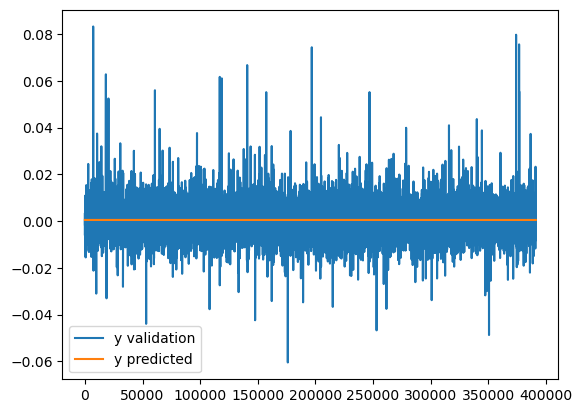

In [84]:
# plot lines 
plt.plot( x , y_test , label = "y test" )
plt.plot( x , y_pred_LSTM_model, label = "y predicted" )
plt.legend() 
plt.show()